# **IRB Retail Mortgage**
# **PD Model Calibration and Validation**

This notebook evaluates the robustness, stability, and calibration of the developed PD model. While the model specification and coefficients were finalised using the full development universe, this notebook assesses whether the frozen model behaves consistently across different data slices, thereby validating its suitability for deployment and regulatory use.

## **Loading the Dataset**

In [1]:
# importing the required modules
import sys
sys.path.append("..")

from src.config import *
from src.utility_functions import *

In [2]:
# loading the dataset after modelling
model_df = save_as_pickle_if_not_exists_and_load(pickle_file_path = f"{main_dir}/data/processed/mortgage_data_with_predictions.pkl")
model_df.head(5)

Pickle file already exists at: /Users/sharmadipanshu/Developer/KPMG/irb_retail_pd_sas_vs_python//data/processed/mortgage_data_with_predictions.pkl
(2260668, 86)


,id,term,loan_amnt,int_rate,installment,grade,sub_grade,purpose,verification_status,annual_inc,emp_length,home_ownership,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,t0,default_flag,clubbed_term,clubbed_sub_grade,clubbed_purpose,clubbed_verification_status,clubbed_home_ownership,clubbed_emp_length,clubbed_term_woe,clubbed_term_iv,clubbed_sub_grade_woe,clubbed_sub_grade_iv,clubbed_purpose_woe,clubbed_purpose_iv,clubbed_verification_status_woe,clubbed_verification_status_iv,clubbed_home_ownership_woe,clubbed_home_ownership_iv,clubbed_emp_length_woe,clubbed_emp_length_iv,delinq_2yrs_adj,clubbed_delinq_2yrs,clubbed_delinq_2yrs_woe,clubbed_delinq_2yrs_iv,inq_last_6mths_adj,clubbed_inq_last_6mths,clubbed_inq_last_6mths_woe,clubbed_inq_last_6mths_iv,pub_rec_adj,clubbed_pub_rec,clubbed_pub_rec_woe,clubbed_pub_rec_iv,open_acc_adj,clubbed_open_acc,clubbed_open_acc_woe,clubbed_open_acc_iv,total_acc_adj,clubbed_total_acc,clubbed_total_acc_woe,clubbed_total_acc_iv,loan_amnt_category,loan_amnt_bin_id,loan_amnt_woe,int_rate_category,int_rate_bin_id,int_rate_woe,installment_category,installment_bin_id,installment_woe,annual_inc_category,annual_inc_bin_id,dti_category,dti_bin_id,revol_bal_category,revol_bal_bin_id,revol_bal_woe,revol_util_category,revol_util_bin_id,dti_bin_id_adj,annual_inc_bin_id_adj,revol_util_bin_id_adj,dti_woe,annual_inc_woe,revol_util_woe,pd_hat,decile
774204,139972821,60 months,10400.0000,22.3500,289.3200,D,D5,debt_consolidation,Not Verified,0.0000,NaN,RENT,NaN,1.0000,1.0000,5.0000,0.0000,0.0000,NaN,23.0000,2018-09-30,0,60 months,D5,1. medium_risk,Not Verified,1. rent,unknown,-0.3569,0.0419,-0.6693,0.0122,-0.0923,0.0051,0.4333,0.0524,-0.1773,0.0133,-0.2178,0.0033,1,1,-0.0810,0.0008,1,1,-0.1399,0.0053,0,0,0.0475,0.0019,2. 3_5,2. 3_5,0.1796,0.0028,4. 21_30,4. 21_30,-0.0119,0.0000,10025.0 - 15000.0,3,-0.0778,20.9 - 30.99,8,-0.9367,230.64 - 327.69,2,0.0459,0.0 - 39502.0,0,missing,-1,0.0 - 22577.0,0,-0.0333,missing,-1,0,0,0,0.3402,-0.2090,0.4562,0.1937,8
1488539,135666561,60 months,12000.0000,17.4700,301.2800,D,D1,credit_card,Not Verified,0.0000,NaN,RENT,NaN,0.0000,0.0000,1.0000,0.0000,0.0000,NaN,3.0000,2018-06-30,0,60 months,D1,0. low_risk,Not Verified,1. rent,unknown,-0.3569,0.0419,-0.4494,0.0086,0.2187,0.0135,0.4333,0.0524,-0.1773,0.0133,-0.2178,0.0033,0,0,0.0289,0.0007,0,0,0.1971,0.0220,0,0,0.0475,0.0019,1. 0_2,1. 0_2,0.2806,0.0004,1. 0_5,1. 0_5,0.1930,0.0005,10025.0 - 15000.0,3,-0.0778,15.1 - 17.47,6,-0.4327,230.64 - 327.69,2,0.0459,0.0 - 39502.0,0,missing,-1,0.0 - 22577.0,0,-0.0333,missing,-1,0,0,0,0.3402,-0.2090,0.4562,0.1414,6
2081649,122649959,36 months,16800.0000,9.9300,541.5400,B,B2,debt_consolidation,Not Verified,0.0000,NaN,MORTGAGE,NaN,0.0000,0.0000,2.0000,0.0000,0.0000,NaN,10.0000,2017-11-30,0,36 months,B2,1. medium_risk,Not Verified,0. owned,unknown,0.1765,0.0207,0.6412,0.0180,-0.0923,0.0051,0.4333,0.0524,0.1304,0.0098,-0.2178,0.0033,0,0,0.0289,0.0007,0,0,0.1971,0.0220,0,0,0.0475,0.0019,1. 0_2,1. 0_2,0.2806,0.0004,2. 6_10,2. 6_10,0.1058,0.0009,15025.0 - 40000.0,4,-0.0971,8.88 - 10.47,2,0.6826,327.7 - 1246.76,3,-0.0898,0.0 - 39502.0,0,missing,-1,0.0 - 22577.0,0,-0.0333,missing,-1,0,0,0,0.3402,-0.2090,0.4562,0.0486,1
2100238,123937016,36 months,20000.0000,10.4200,649.3000,B,B3,debt_consolidation,Not Verified,0.0000,NaN,MORTGAGE,NaN,1.0000,0.0000,2.0000,0.0000,0.0000,NaN,13.0000,2017-11-30,0,36 months,B3,1. medium_risk,Not Verified,0. owned,unknown,0.1765,0.0207,0.4299,0.0091,-0.0923,0.0051,0.4333,0.0524,0.1304,0.0098,-0.2178,0.0033,1,1,-0.0810,0.0008,0,0,0.1971,0.0220,0,0,0.0475,0.0019,1. 0_2,1. 0_2,0.2806,0.0004,3. 11_20,3. 11_20,0.0264,0.0002,15025.0 - 40000.0,4,-0.0971,8.88 - 10.47,2,0.6826,327.7 - 1246.76,3,-0.0898,0.0 - 39502.0,0,missing,-1,0.0 - 22577.0,0,-0.0333,missing,-1,0,0,0,0.3402,-0.2090,0.4562,0.0580,2
1654329,79967,36 months,5000.0000,7.4300,155.3800,A,A2,other,Not Verified,NaN,< 1 year,NONE,1.0000,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,2007-08-31,0,36 months,A2,2. high_ri

In [3]:
# loading the final model 
final_model_summary = pd.read_excel(f"{main_dir}/summaries_and_charts/final_model_metrics.xlsx", sheet_name=None)
final_model_summary.keys()

dict_keys(['final_model_summary', 'decile_summary', 'statistics'])

## **Calibration and Validation Sample (OOT)**

Given the snapshot nature of the available dataset, the model was developed using the full sample to ensure robust variable selection and stable coefficient estimation. Sice the recent dataset is not available, the validation exercise conducted in this notebook represents a pseudo out-of-time (OOT) analysis, rather than a fully independent holdout validation. The purpose of this pseudo-OOT analysis is not to re-assess model specification, but to evaluate the stability, rank-order preservation, and calibration behaviour of the frozen model across different time slices. This approach is consistent with industry practice when true OOT samples are not available and is intended to demonstrate key elements of the IRB model development and validation lifecycle.

In [4]:
model_df['year'] = model_df.t0.dt.year 
display(model_df.t0.value_counts(dropna=False).sort_index())
display(model_df.year.value_counts(dropna=False).sort_index())

t0
2007-06-30       24
2007-07-31       63
2007-08-31       74
2007-09-30       53
2007-10-31      105
              ...  
2018-08-31    46079
2018-09-30    39026
2018-10-31    46305
2018-11-30    41973
2018-12-31    40134
Name: count, Length: 139, dtype: int64

year
2007       603
2008      2393
2009      5281
2010     12537
2011     21721
2012     53367
2013    134814
2014    235629
2015    421095
2016    434407
2017    443579
2018    495242
Name: count, dtype: int64

In [5]:
# we have the dataset from Jun'2007 to Dec'2028
# lets calculate the yearwise default rate and then create 5 years window and calculate the LRADR

yearwise_default_rate = model_df.groupby('year').agg({'default_flag' : ['count', 'sum', 'mean']}).reset_index()
display(yearwise_default_rate)

for year in range(2007, 2015):
    print(f"LRADR Period {year} - {year+4} : {round(yearwise_default_rate[yearwise_default_rate[('year', '')].between(year, year+4)][('default_flag', 'mean')].mean()*100,4)}%")

print(f"LRADR 2007 - 2018 : {round(yearwise_default_rate[('default_flag', 'mean')].mean()*100, 4)}%")


year default_flag              
                count    sum   mean
0   2007          603    158 0.2620
1   2008         2393    496 0.2073
2   2009         5281    723 0.1369
3   2010        12537   1757 0.1401
4   2011        21721   3297 0.1518
5   2012        53367   8644 0.1620
6   2013       134814  21024 0.1559
7   2014       235629  41162 0.1747
8   2015       421095  75804 0.1800
9   2016       434407  68252 0.1571
10  2017       443579  39169 0.0883
11  2018       495242   8874 0.0179

LRADR Period 2007 - 2011 : 17.9627%
LRADR Period 2008 - 2012 : 15.9617%
LRADR Period 2009 - 2013 : 14.9352%
LRADR Period 2010 - 2014 : 15.6909%
LRADR Period 2011 - 2015 : 16.4883%
LRADR Period 2012 - 2016 : 16.5949%
LRADR Period 2013 - 2017 : 15.1214%
LRADR Period 2014 - 2018 : 12.3608%
LRADR 2007 - 2018 : 15.2841%


The available dataset spans loan vintages from June 2007 to December 2018, with a material increase in portfolio size and data completeness from 2012 onwards. Earlier vintages (2007–2010) exhibit relatively low observation counts and are heavily influenced by the global financial crisis, making them less representative of the current risk profile of the portfolio. Consequently, for the purpose of calibration and validation, the analysis focuses on the more recent and statistically robust period starting from 2013, where annual observations exceed 130,000 accounts and default behaviour stabilises.

In line with industry practice and supervisory expectations for IRB models, a five-year window (2013–2017) is selected as the calibration sample to estimate the Long-Run Average Default Rate (LRADR) and perform portfolio-level PD alignment. This period provides sufficient depth to smooth short-term volatility while remaining representative of recent credit conditions. The 2018 vintage, comprising approximately 495,000 observations, is designated as the out-of-time (OOT) validation sample. Although the model was developed using the full snapshot of data, this split enables a pseudo-OOT assessment of rank-order stability, calibration behaviour, and score distribution consistency across time, thereby supporting the evaluation of model robustness and fitness for use.

In [6]:
calibration_period = (2013, 2017)
oot_period = (2018, 2018)

calib_data = model_df[model_df.year.between(calibration_period[0], calibration_period[1])]
oot_data = model_df[model_df.year.between(oot_period[0], oot_period[1])]
print(calib_data.shape, oot_data.shape)

(1669524, 87) (495242, 87)


### **LRADR and Calibration**

In [7]:
# calculating the scorebased on the final selected model
final_vars = final_model_summary['final_model_summary']['variable'].to_list()
final_vars.remove('const')

# extract coefficients (including intercept)
coef_df = final_model_summary['final_model_summary'].set_index('variable')
intercept = coef_df.loc['const', 'coefficient']
betas = coef_df.loc[final_vars, 'coefficient']

# apply frozen model
calib_data['pd_raw'] = score_pd(calib_data, betas, intercept)
oot_data['pd_raw']   = score_pd(oot_data, betas, intercept)

display(calib_data[['pd_raw']].describe()) 
display(oot_data[['pd_raw']].describe())

# calculating the target (LRADR) and existing average predicted PD
LRADR = calib_data.groupby('year').agg({'default_flag' : 'mean'}).reset_index()['default_flag'].mean()
avg_pd_calib = calib_data.pd_raw.mean()
print(f"Target (LRADR) : {round(LRADR*100,4)}%\nAverage Existing Predicted PD: {round(avg_pd_calib*100,4)}%") 


,pd_raw
count,1669524.0000
mean,0.1244
std,0.0811
min,0.0096
25%,0.0645
50%,0.1088
75%,0.1648
max,0.5687


,pd_raw
count,495242.0000
mean,0.1007
std,0.0682
min,0.0084
25%,0.0462
50%,0.0875
75%,0.1400
max,0.5289


Target (LRADR) : 15.1214%
Average Existing Predicted PD: 12.4426%


$$\Delta = log(\frac{LRADR}{1-LRADR}) - log(\frac{\bar{PD}}{1-\bar{PD}})$$

Δ represents the difference between long-run log-odds of default and the model-implied log-odds of default

Economically:
- If Δ > 0 → model under-predicts risk → shift PDs upward
- If Δ < 0 → model over-predicts risk → shift PDs downward

Crucially:
- Only the intercept is adjusted
- Rank-ordering and marginal effects remain intact

This is intercept-only calibration, as expected under IRB.

In [8]:
# intercept shift (delta)
delta = np.log(LRADR / (1 - LRADR)) - np.log(avg_pd_calib / (1 - avg_pd_calib))
print(f"Intercept Shift (Delta): {round(delta, 6)}")

# applying calibrated PDs — calibration sample
calib_data['pd_calibrated'] = 1 / (1 + np.exp(-(np.log(calib_data['pd_raw'] / (1 - calib_data['pd_raw'])) + delta)))

# applying calibrated PDs — OOT sample
oot_data['pd_calibrated'] = 1 / (1 + np.exp(-(np.log(oot_data['pd_raw'] / (1 - oot_data['pd_raw'])) + delta)))

# Validation check
print("Post-calibration average PD (Calibration sample):", round(calib_data['pd_calibrated'].mean()*100, 4), "%")
print("LRADR: ", round(LRADR*100, 4), "%")

Intercept Shift (Delta): 0.226059
Post-calibration average PD (Calibration sample): 14.9349 %
LRADR:  15.1214 %


The PD model is calibrated using an intercept-only adjustment to align portfolio-level predicted default rates with the Long-Run Average Default Rate (LRADR), estimated over the 2013–2017 calibration window. The LRADR for this period is 15.12%, representing a stable long-run estimate of portfolio credit risk after smoothing cyclical fluctuations.

Following the application of the calibrated intercept, the average predicted PD on the calibration sample increases from 12.44% (pre-calibration) to 14.93% (post-calibration), bringing the model outputs into close alignment with the LRADR. The residual difference of approximately 19 basis points is economically immaterial and arises due to the non-linear transformation between log-odds and probability space, as well as differences between population-weighted PD averages and time-averaged default rates.

Importantly, the calibration is performed through an intercept-only shift, leaving all slope coefficients unchanged. As a result, the model’s rank-ordering, relative risk differentiation, and discriminatory power are fully preserved. This calibration approach is consistent with IRB modelling principles and ensures portfolio-level PD alignment while maintaining model stability and interpretability.

### **Sample Performance**

#### **Calibration**

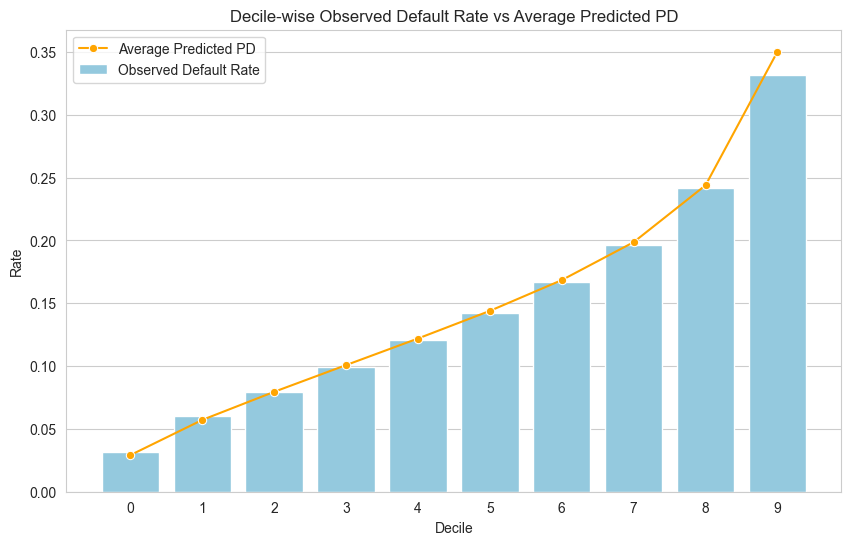

AUC: 69.34%
Final Model Gini: 38.67%
KS Statistic: 0.2786


,decile,population,defaults,avg_pd,obs_default_rate,cum_good,cum_bad,ks
0,0,167371,5300,0.0291,0.0317,0.1138,0.0216,0.0922
1,1,166620,10000,0.0572,0.0600,0.2238,0.0623,0.1614
2,2,166879,13299,0.0795,0.0797,0.3316,0.1165,0.2151
3,3,166945,16558,0.1008,0.0992,0.4372,0.1840,0.2532
4,4,166947,20164,0.1219,0.1208,0.5403,0.2662,0.2741
5,5,166991,23756,0.1439,0.1423,0.6409,0.3630,0.2779
6,6,166914,27871,0.1684,0.1670,0.7385,0.4765,0.2620
7,7,166954,32736,0.1986,0.1961,0.8328,0.6099,0.2228
8,8,166968,40365,0.2439,0.2418,0.9217,0.7744,0.1472
9,9,166935,55362,0.3502,0.3316,1.0000,1.0000,0.0000


In [11]:
calib_decile_summary, calib_decile_fig, calib_auc, calib_gini, calib_ks = performance_summary(calib_data, 'pd_calibrated', 'default_flag', 10)

print(f"AUC: {round(calib_auc*100, 2)}%")
print(f"Final Model Gini: {round(calib_gini*100, 2)}%")
print(f"KS Statistic: {calib_ks:.4f}")
display(calib_decile_summary)

On the calibration sample, the calibrated model demonstrates strong discriminatory power and good calibration alignment. The AUC of 69.3% (Gini 38.7%) and KS of 0.279 are consistent with the development-stage performance observed in Notebook 03, indicating that the frozen model structure remains stable when reapplied to the calibration window. Rank-ordering is well preserved, with a smooth and monotonic increase in observed default rates across deciles, confirming that the model effectively separates higher-risk from lower-risk accounts.

From a calibration perspective, the intercept-only adjustment successfully aligns the portfolio-level average predicted PD with the Long-Run Average Default Rate (LRADR) estimated over the five-year window. Post-calibration, the average predicted PD in the calibration sample closely matches the LRADR, with only a small residual difference attributable to rounding and numerical aggregation effects. At the decile level, predicted PDs track observed default rates reasonably well, particularly in the central deciles, indicating that the calibration shift preserves relative risk differentiation while correcting level bias at the portfolio level.

Overall, the calibration results confirm that the model is well-calibrated on a long-run representative sample, with no evidence of rank-order instability or excessive concentration of risk in individual deciles.

#### **OOT**

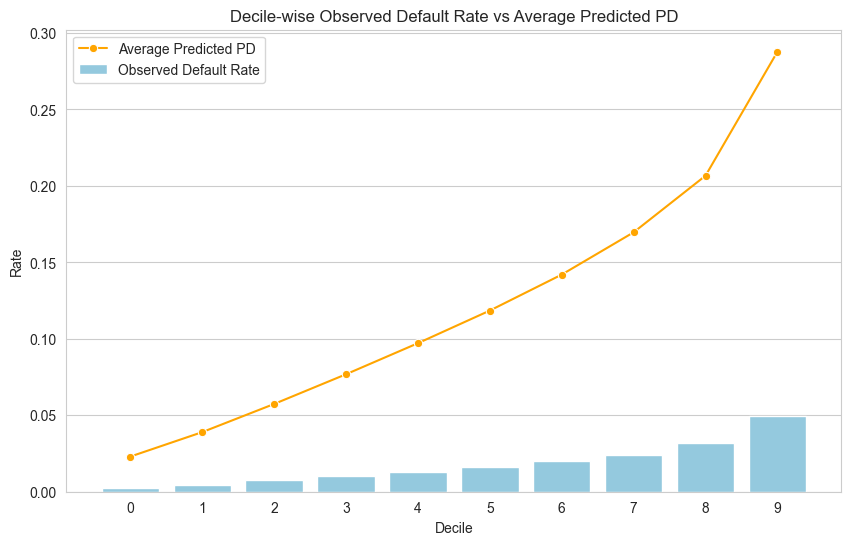

AUC: 70.98%
Final Model Gini: 41.95%
KS Statistic: 0.3054


,decile,population,defaults,avg_pd,obs_default_rate,cum_good,cum_bad,ks
0,0,49553,130,0.0230,0.0026,0.1016,0.0146,0.0870
1,1,49496,217,0.0390,0.0044,0.2029,0.0391,0.1638
2,2,49566,388,0.0574,0.0078,0.3040,0.0828,0.2212
3,3,49509,507,0.0768,0.0102,0.4048,0.1400,0.2648
4,4,49539,628,0.0971,0.0127,0.5054,0.2107,0.2946
5,5,49600,807,0.1185,0.0163,0.6057,0.3017,0.3040
6,6,49408,987,0.1420,0.0200,0.7052,0.4129,0.2924
7,7,49527,1193,0.1696,0.0241,0.8046,0.5473,0.2573
8,8,49520,1575,0.2066,0.0318,0.9032,0.7248,0.1784
9,9,49524,2442,0.2877,0.0493,1.0000,1.0000,0.0000


In [15]:
oot_decile_summary, oot_decile_fig, oot_auc, oot_gini, oot_ks = performance_summary(oot_data, 'pd_calibrated', 'default_flag', 10)

print(f"AUC: {round(oot_auc*100, 2)}%")
print(f"Final Model Gini: {round(oot_gini*100, 2)}%")
print(f"KS Statistic: {oot_ks:.4f}")
display(oot_decile_summary)

In the OOT sample (2018), the model continues to exhibit strong discriminatory performance, with an AUC of 71.0% (Gini 42.0%) and KS of 0.305—both marginally higher than those observed in the calibration sample. This indicates that the rank-ordering capability of the model remains robust out of time, and that relative risk signals learned during development continue to generalise well to later vintages.

However, a clear level misalignment is observed between predicted PDs and realised default rates in the OOT period. Across all deciles, the model systematically over-predicts default risk, with observed default rates substantially lower than calibrated PDs. This behaviour is economically intuitive and consistent with earlier portfolio-level analysis, which showed that 2018 exhibits the lowest annual default rate (~1.8%) in the dataset, reflecting a benign credit environment and improved borrower performance relative to the long-run average.

Importantly, this over-prediction does not indicate model failure. The calibration was intentionally anchored to the LRADR rather than to point-in-time conditions, in line with IRB principles. As a result, in periods where realised default rates fall materially below long-run levels, conservative bias in predicted PDs is expected and, from a regulatory perspective, desirable. Crucially, rank-order stability is preserved in the OOT sample, with monotonic observed default rates across deciles and no evidence of score inversion.

### **Stability Diagnostics**